<a href="https://colab.research.google.com/github/ablet-imin/Max-LL/blob/main/Max_log_likelihood_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binned likelihood

Codes are taken from `Benjamin J. Land`'s example.   
Original examples here: https://ben.land/post/2021/01/09/maximum-likelihood-python/


In [4]:
import numpy as np
from scipy.stats import poisson
import scipy.optimize as opt
import matplotlib.pyplot as plt

#Make plots prety
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams ['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family']= 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3
matplotlib.rcParams['figure.facecolor'] = (1,1,1)

# 1D histogram with 40 bins in [0 - 25] MeV
binning = np.linspace(0, 25, 40)

# MC event generator
def EvGen_Gauss(mean, std, nev):
    return np.random.normal(mean, std, nev)


Two type of events, class a and b.  
MC simulation is based on the normal distributio,
with N(10, 2) and N(15, 3).

This two template will be used to estimate PDF of two classes.

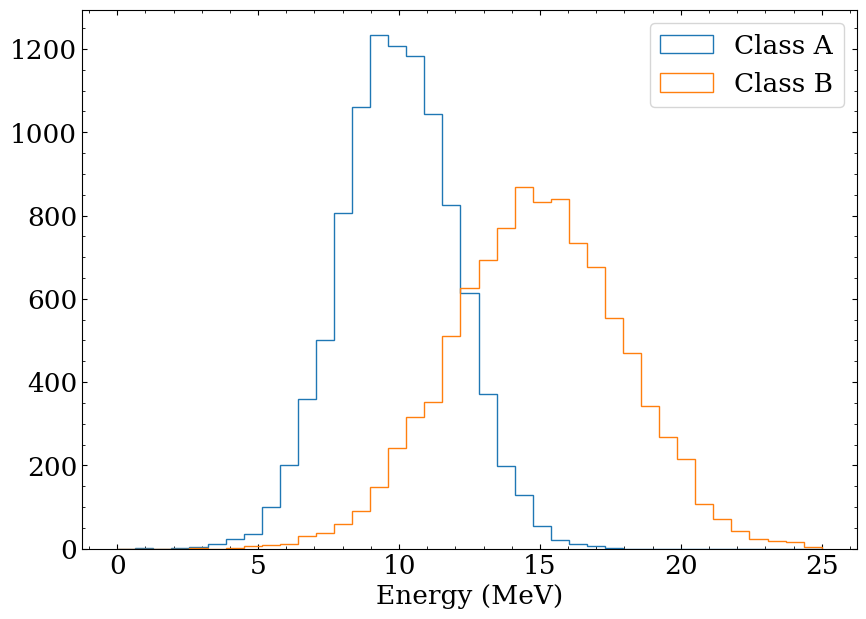

In [6]:
# 10000 events for each class
MC_EVENTS = 10000
m_a, std_a = 10, 2
m_b, std_b = 15, 3
mc_class_a = EvGen_Gauss(m_a, std_a, MC_EVENTS)
mc_class_b = EvGen_Gauss(m_b, std_b, MC_EVENTS)

# Histograms of two class
plt.hist(mc_class_a, bins=binning, histtype="step", label="Class A")
plt.hist(mc_class_b, bins=binning, histtype="step", label="Class B")
plt.xlabel("Energy (MeV)")
plt.legend()


## Generate data
Data is a mixture of class a and class b events.

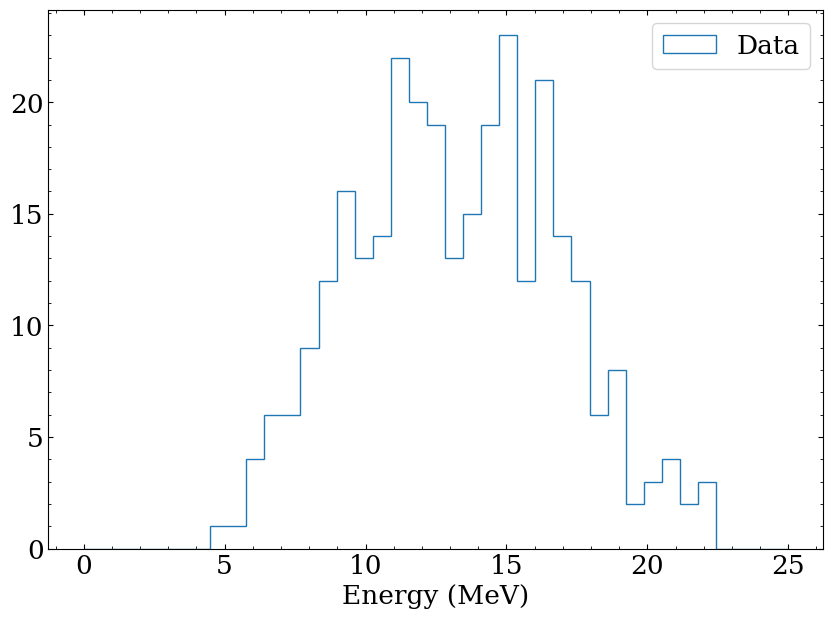

In [7]:
# a psudo-data
# mixture of 100 events from class a
# and 200 events from class b

data = np.concatenate([EvGen_Gauss(m_a, std_a, 100),
                       EvGen_Gauss(m_b, std_b, 200)]
)

plt.hist(data, bins=binning, histtype="step", label="Data")
plt.xlabel("Energy (MeV)")
plt.legend()

# Binned likelihood construction

In [12]:
# PDF of class a and class b
def get_pdf(d):
    bin_counts = np.histogram(d, bins=binning)[0]
    return bin_counts/np.sum(bin_counts)

def LL(*params):
    class_pdfs = [get_pdf(mc_class_a), get_pdf(mc_class_b)]
    expecteds = [n*pdf for n, pdf in zip(params, class_pdfs)]
    expected = np.sum(expecteds, axis=0)
    observed = np.histogram(data, bins=binning)[0]

    # probability of each bin
    # Data in each bin follow a poisson
    # mean is equall to expectation in that bin
    bin_probs  = poisson.pmf(observed, expected)

    # likelihoo --> product of bin probalities
    return np.prod(bin_probs)




In [13]:
print(LL(100,200))

3.261121350420956e-30


#Likelihood space


Text(0, 0.5, 'Class B Events')

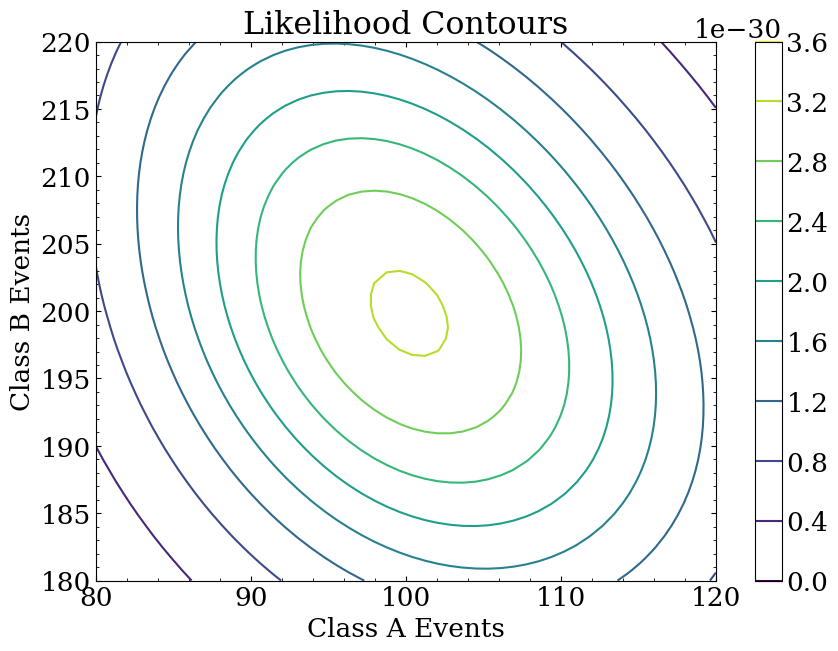

In [23]:
X, Y = np.meshgrid(np.linspace(80,120), np.linspace(180,220))

Z = [LL(x, y) for x, y in zip(X.flatten(), Y.flatten())] # list of length = 50 * 50

# conver Z to 2D matrix with 50,50
Z = np.array(Z).reshape(X.shape)

plt.contour(X, Y, Z)
plt.colorbar()
plt.title("Likelihood Contours")
plt.xlabel("Class A Events")
plt.ylabel("Class B Events")


# Maximum likelihood

In [24]:
# Maximize LL with scipy optimizer
def MLL(par):
    return -LL(*par)
result = opt.minimize(MLL, x0=(50, 50), method="Nelder-Mead")
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -3.261594480450436e-30
             x: [ 1.002e+02  1.998e+02]
           nit: 54
          nfev: 107
 final_simplex: (array([[ 1.002e+02,  1.998e+02],
                       [ 1.002e+02,  1.998e+02],
                       [ 1.002e+02,  1.998e+02]]), array([-3.262e-30, -3.262e-30, -3.262e-30]))


# Binned negative log likelihood function

In [25]:
class NegativeLogLikelihoodFunction:

    # This is the same as before
    def __init__(self,data,event_classes,binning):
        self.data_counts = np.histogram(data,bins=binning)[0]
        self.class_pdfs = []
        for event_class in event_classes:
            pdf_counts = np.histogram(event_class,bins=binning)[0]
            pdf_norm = pdf_counts/np.sum(pdf_counts)
            self.class_pdfs.append(pdf_norm)

    def __call__(self,*params):
        observed = self.data_counts
        expecteds = [scale*pdf for scale,pdf in zip(params,self.class_pdfs)]
        expected = np.sum(expecteds,axis=0)
        # Calculate the bin-by-bin -log(poisson probabilities) sans constant terms
        # Note, regions in your ROI with no expected counts (0 bins in PDF) must be excluded
        mask = expected > 0
        bin_nlls = expected[mask]-observed[mask]*np.log(expected[mask])
        # multiply all the probabilities -> add all negative log likelihoods
        return np.sum(bin_nlls)

In [27]:
nllfn = NegativeLogLikelihoodFunction(data,[mc_class_a,mc_class_b],binning)
print(nllfn(100,200))


-467.0675489999233


In [28]:
# Minimize like before
nll_result = opt.minimize(lambda x: nllfn(*x),x0=(50,50),method='Nelder-Mead')

# Note fun (minimum value), nfev (number of times lfn function called), and x (the minimum location)
print(nll_result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -467.0676940714066
             x: [ 1.002e+02  1.998e+02]
           nit: 54
          nfev: 107
 final_simplex: (array([[ 1.002e+02,  1.998e+02],
                       [ 1.002e+02,  1.998e+02],
                       [ 1.002e+02,  1.998e+02]]), array([-4.671e+02, -4.671e+02, -4.671e+02]))


In [29]:
def profile_class_a(nev):
    '''Profile away class_b scale factor to get 1D delta NLL for class_a'''
    return opt.minimize(lambda x: nllfn(nev,x[0]),x0=(50,),method='Nelder-Mead').fun - nll_result.fun
def profile_class_b(nev):
    '''Profile away class_a scale factor to get 1D delta NLL for class_b'''
    return opt.minimize(lambda x: nllfn(x[0],nev),x0=(50,),method='Nelder-Mead').fun - nll_result.fun


Text(0, 0.5, '-$\\Delta$ Log ${\\scr L}$')

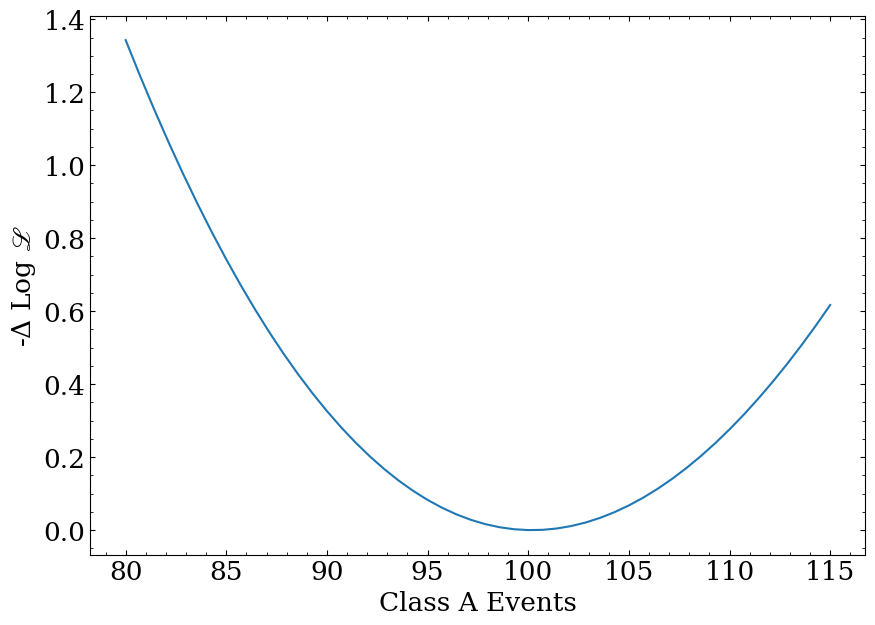

In [30]:
x = np.linspace(80,115,50)
y = [profile_class_a(nev) for nev in x]
plt.plot(x,y)
plt.xlabel('Class A Events')
plt.ylabel('-$\Delta$ Log ${\scr L}$')

Text(0, 0.5, '$\\Delta$ Log ${\\scr L}$')

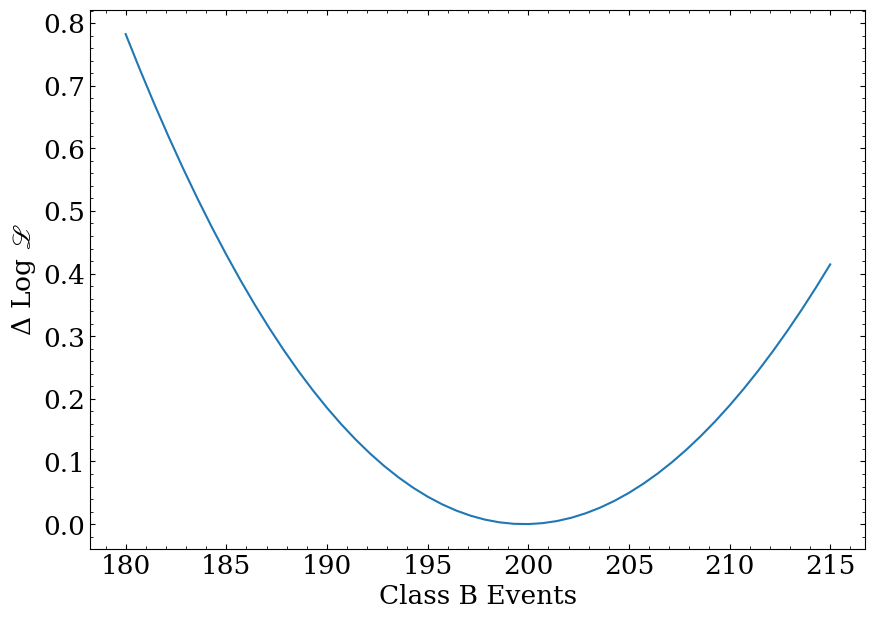

In [31]:
x = np.linspace(180,215,50)
y = [profile_class_b(nev) for nev in x]
plt.plot(x,y)
plt.xlabel('Class B Events')
plt.ylabel('$\Delta$ Log ${\scr L}$')

In [32]:
def confidence_interval(delta_nll_fn,central,step):
    ''' Finds 1sigma confidence interval for a delta_nll_fn of one parameter
        around a central value with a max distance of step.'''
    lo = opt.brentq(lambda x: delta_nll_fn(x)-0.5,central-step,central)
    hi = opt.brentq(lambda x: delta_nll_fn(x)-0.5,central,central+step)
    return lo,hi

central = nll_result.x[0]
lo,hi = confidence_interval(profile_class_a,central,50)
print('Number of A events = $%0.2f^{+%0.2f}_{-%0.2f}$'%(central,hi-central,central-lo))

central = nll_result.x[1]
lo,hi = confidence_interval(profile_class_b,central,50)
print('Number of B events = $%0.2f^{+%0.2f}_{-%0.2f}$'%(central,hi-central,central-lo))

Number of A events = $100.20^{+13.29}_{-12.55}$
Number of B events = $199.80^{+16.72}_{-15.93}$


Number of A events = $100.20^{+13.29}_{-12.55}$  
Number of B events = $199.80^{+16.72}_{-15.93}$